## Import des librairies et base des données


In [76]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import itertools as it
import statsmodels.api as sm

In [77]:
df_corkstation = pd.read_csv('Corkstation_15072019_01022011.csv')
df_vst = pd.read_csv('df_vst_group6.csv')
print(df_corkstation.columns)
df1=df_corkstation
df2=df_vst


Index(['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt',
       'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w',
       'sun', 'vis', 'clht', 'clamt'],
      dtype='object')


## Interpolation des données manquantes et Rassemblement des deux datasets


### Prétraitement


Interpolating incomplete data from df_corkstation

In [78]:
# Changing index to date column
df_corkstation['date'] = pd.to_datetime(df_corkstation['date'])
df_corkstation.set_index('date', inplace=True)

# Interpolating over missing data
df_corkstation = df_corkstation.replace({' ': '-1'}, regex=True)
df_corkstation['wetb'] = pd.to_numeric(df_corkstation['wetb'])
df_corkstation['vis'] = pd.to_numeric(df_corkstation['vis'])
df_corkstation = df_corkstation.replace({-1: np.nan}, regex=True)
df_corkstation = df_corkstation.interpolate()

Resample and interpolating

In [79]:
# Resample for each 30 min and interpolating
df_corkstation_resampled = df_corkstation.resample('30T').interpolate(method='linear')

Adding week-end, season info

In [80]:
# Lists to be used
weekend_list = []
season_list = []
work_time_list = []
year_list = []
month_list = []
day_list = []
hour_list = []
minute_list=[]
weekofyear_list = []
hours_array = [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]         # 1 ... 24
 
# Get season function
def get_season(date):
    year = date.year
    seasons = {
        'spring': (pd.Timestamp(year=year, month=3, day=21), pd.Timestamp(year=year, month=6, day=20)),
        'summer': (pd.Timestamp(year=year, month=6, day=20), pd.Timestamp(year=year, month=9, day=20)),
        'fall': (pd.Timestamp(year=year, month=9, day=21), pd.Timestamp(year=year, month=12, day=20)),
        'winter': (pd.Timestamp(year=year, month=12, day=21), pd.Timestamp(year=year + 1, month=3, day=19))
    }
    
    if seasons['spring'][0] <= date <= seasons['spring'][1]:
        return 1
    elif seasons['summer'][0] <= date <= seasons['summer'][1]:
        return 2
    elif seasons['fall'][0] <= date <= seasons['fall'][1]:
        return 3
    else:
        return 4
    
# Adding info to lists
for date in df_corkstation_resampled.index.tolist():
    if date.weekday() == 5 or date.weekday() == 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)

    season_list.append(get_season(date))
    year_list.append(date.year)
    month_list.append(date.month)
    day_list.append(date.day)
    hour_list.append(date.hour)
    minute_list.append(date.minute)
    weekofyear_list.append(date.weekofyear)

    if date.hour >= 9 and date.hour <= 18:
        work_time_list.append(1)
    else:
        work_time_list.append(0)

    #for hour in range(1, 25):
    #    if hour == date.hour:
    #        hours_array[hour-1].append(1)
    #    else:
    #        hours_array[hour-1].append(0)

# Creating dataframes with info
weekend_df = pd.DataFrame({'weekend': weekend_list})
season_df = pd.DataFrame({'season': season_list})
work_time_df = pd.DataFrame({'work_time': work_time_list})
year_df = pd.DataFrame({'year': year_list})
month_df = pd.DataFrame({'month': month_list})
day_df = pd.DataFrame({'day': day_list})
hour_df = pd.DataFrame({'hour': hour_list})
minute_df = pd.DataFrame({'minute': minute_list})
weekofyear_df = pd.DataFrame({'weekofyear': weekofyear_list})

#hours_dfs = []
#for hour in range(1, 25):
#    hours_dfs.append(pd.DataFrame({f'hour{hour}': hours_array[hour-1]}))
#hours_df = pd.concat(hours_dfs, axis=1)

# Concating created info to the dataframe corkstation
time_info = pd.concat([weekend_df, season_df, work_time_df, year_df, month_df, day_df, hour_df, minute_df, weekofyear_df], axis=1)
time_info.set_index(df_corkstation_resampled.index, inplace=True)
df_corkstation_resampled = pd.concat([df_corkstation_resampled, time_info], axis=1)

Deleting last data from dataframes to match the consumption data

In [81]:
date_to_be_cropped = datetime.datetime(2010, 12, 14, 23, 30)
df_corkstation_cropped = df_corkstation_resampled[df_corkstation_resampled.index <= date_to_be_cropped]

df_vst['time'] = pd.to_datetime(df_vst['time'])
df_vst.set_index('time', inplace=True)
df_vst_cropped = df_vst[df_vst.index<=date_to_be_cropped]


date_to_be_cropped_ = datetime.datetime(2010,12 ,31 , 23, 30)
df_corkstation_cropped_ = df_corkstation_resampled[df_corkstation_resampled.index <= date_to_be_cropped_]

df_vst_cropped_ = df_vst[df_vst.index<=date_to_be_cropped_]





Merging two dataframes

In [82]:
df_corkstation_cropped = df_corkstation_cropped.drop(columns=['temp'])
df_corkstation_cropped_ = df_corkstation_cropped_.drop(columns=['temp'])
df_to_train_and_test = pd.concat([df_corkstation_cropped, df_vst_cropped], axis=1)
df_to_train_and_test_ = pd.concat([df_corkstation_cropped_, df_vst_cropped_], axis=1)

## Analyse des données et obtention des meilleures variables avec le critère AIC

In [83]:
def best_aic(df): 
    y = df['mean']
    X = df.drop(columns=['mean', 'ind.3', 'ind.4','rain','ww','w','weekend','month','minute','clamt','year','day'])
    X = sm.add_constant(X)
    
    selected_features = []
    remaining_features = list(X.columns)
    remaining_features.remove('const')
    
    current_score, best_new_score = float('inf'), float('inf')
    while remaining_features:
        scores_with_candidates = []
        for candidate in remaining_features:
            candidates = selected_features + [candidate]
            X_subset = X[candidates]
            model = sm.OLS(y, X_subset).fit()
            score = model.aic
            scores_with_candidates.append((score, candidate))
        
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates[0]
        
        if current_score > best_new_score:
            remaining_features.remove(best_candidate)
            selected_features.append(best_candidate)
            current_score = best_new_score
        else:
            break
    
    return selected_features

best_features = best_aic(df_to_train_and_test)
print(f'Best Features: {best_features}')

Best Features: ['hour', 'season', 'work_time', 'temp', 'msl', 'wetb', 'ind', 'weekofyear', 'ind.1', 'vappr', 'wddir', 'clht', 'rhum', 'dewpt']


## Régression multilinéaire

ind              3.000000
rain             0.000000
ind.1            0.500000
ind.2            1.000000
wetb            -0.300000
dewpt           -0.875000
vappr            5.700000
rhum            93.000000
msl           1042.350000
ind.3            2.000000
wdsp             8.000000
ind.4            2.000000
wddir          335.000000
ww              10.000000
w                0.000000
sun              0.000000
vis           8000.000000
clht           999.000000
clamt            0.000000
weekend          0.000000
season           3.000000
work_time        0.000000
year          2010.000000
month           12.000000
day             14.000000
hour            23.000000
minute          30.000000
weekofyear      50.000000
mean             0.568014
temp             0.050000
Name: 2010-12-14 23:30:00, dtype: float64
                     mean  hour  season  work_time  temp      msl  wetb  ind  \
2010-12-15 00:00:00   NaN     0       3          0 -0.10  1042.30 -0.40  3.0   
2010-12-15 00:30:0

C:\Users\Alisson Bonatto\AppData\Local\Temp\ipykernel_25420\3196856624.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_consumption'] = y_pred


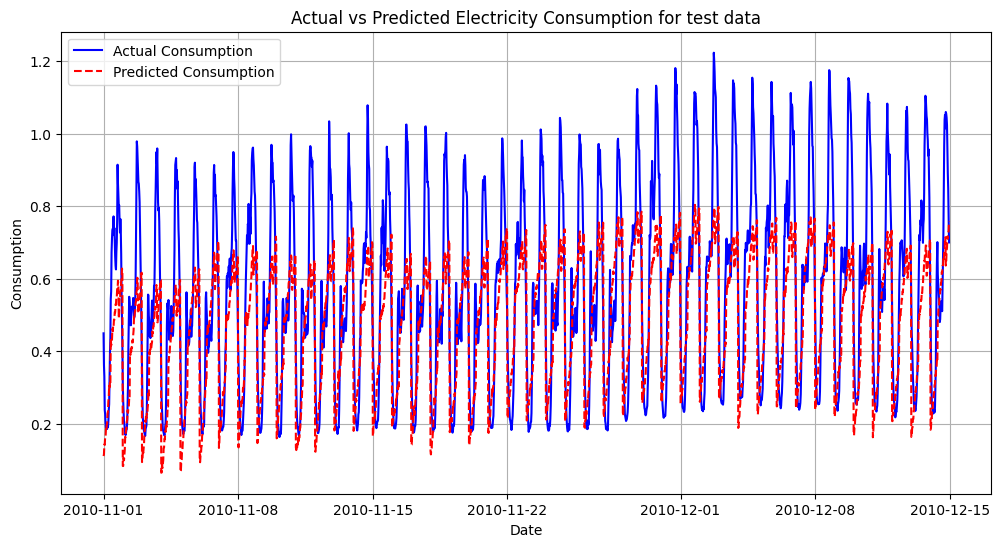

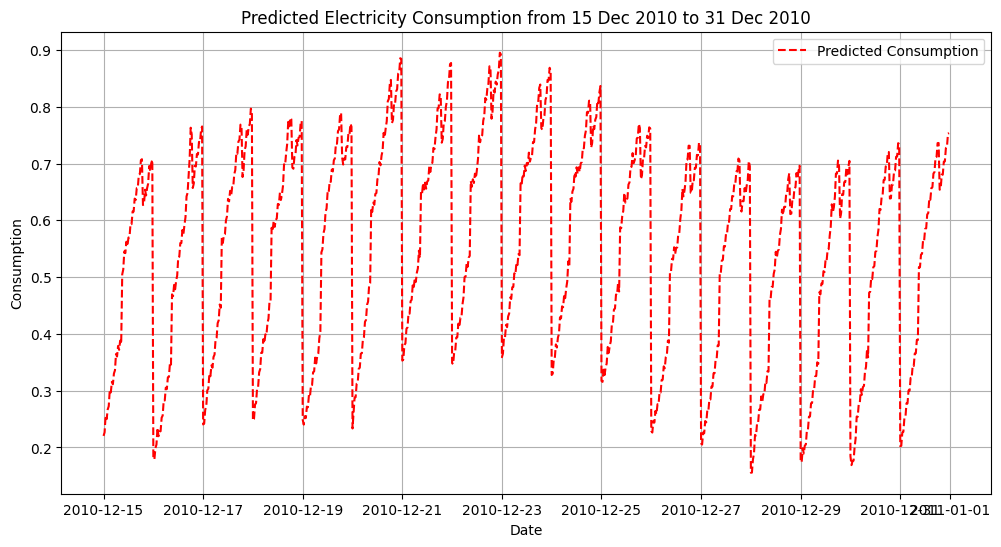

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Assumons que df_to_train_and_test est votre DataFrame avec les colonnes 'temp', 'humidity', 'season', 'rain', etc.
# et que 'mean' est la variable cible
df = df_to_train_and_test_
# Filtrer les données de septembre 2009 à décembre 2010
begin_date = datetime.datetime(2009, 7, 15, 0, 0)
end_date = datetime.datetime(2010, 12, 31, 23, 30)
df = df[(df.index >= begin_date) & (df.index <= end_date)][['mean' ,'hour', 'season', 'work_time', 'temp', 'msl', 'wetb', 'ind', 'weekofyear', 'ind.1', 'vappr', 'wddir', 'clht', 'rhum', 'dewpt']] # choix des paramètres

# Créer un DataFrame contenant les données du 15 au 31 décembre 2010 pour la prédiction
begin_date1 = datetime.datetime(2010, 12, 15, 0, 0)
end_date1 = datetime.datetime(2010, 12, 31, 23, 30)
print(df_to_train_and_test.iloc[-1])
future_data = df[(df.index >= begin_date1) & (df.index <= end_date1)][['mean' ,'hour', 'season', 'work_time', 'temp', 'msl', 'wetb', 'ind', 'weekofyear', 'ind.1', 'vappr', 'wddir', 'clht', 'rhum', 'dewpt']] # choix des paramètres
df = df[df.index < date_to_be_cropped]

# Assurez-vous que l'index est de type datetime
df.index = pd.to_datetime(df.index)
future_data.index = pd.to_datetime(future_data.index)

# Ajouter des caractéristiques temporelles
# Capture les intervalles de 30 minutes

# Capture les intervalles de 30 minutes

# Définir la période de test pour décembre 2009
start_time_test = pd.Timestamp('2010-11-1 00:00:00')
end_time_test = pd.Timestamp('2010-12-14 23:59:59')

# Filtrer les données pour l'entraînement et le test
train_data = df[df.index < start_time_test]
test_data = df[(df.index >= start_time_test) & (df.index <= end_time_test)]

# Séparer les caractéristiques et la cible
X_train = train_data.drop(columns=['mean'])
y_train = train_data['mean']
X_test = test_data.drop(columns=['mean'])
y_test = test_data['mean']

# Normaliser les données (optionnel mais recommandé)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print(future_data)
future_data_scaled = scaler.transform(future_data.drop(columns=['mean']))

# Créer et ajuster le modèle de régression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Faire des prédictions
y_pred = model.predict(X_test_scaled)
future_consumption_pred = model.predict(future_data_scaled)

# Ajouter les prédictions au DataFrame future_data
future_data['predicted_consumption'] = future_consumption_pred

# Ajouter les prédictions au DataFrame test_data pour visualisation
test_data['predicted_consumption'] = y_pred

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f'R^2: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape * 100:.2f}%')

# Visualiser les résultats pour décembre 2009
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Consumption', color='blue')
plt.plot(test_data.index, y_pred, label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Actual vs Predicted Electricity Consumption for test data')
plt.legend()
plt.grid(True)
plt.show()

# Visualiser les résultats pour la période de prédiction (15 au 31 décembre 2010)
plt.figure(figsize=(12, 6))
plt.plot(future_data.index, future_data['predicted_consumption'], label='Predicted Consumption', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.title('Predicted Electricity Consumption from 15 Dec 2010 to 31 Dec 2010')
plt.legend()
plt.grid(True)
plt.show()
